# Getting Started with the Air Force Arcade

---

In this notebook, we will introduce you to the Air Force Arcade and reinforcement learning by demonstrating some basic functionality of the environments, the basics of gym environments, and finally will train a small [Deep Q Network (DQN)](https://arxiv.org/pdf/1312.5602.pdf) to get you started.

## Step 0: About the Environment

The `DroneDodgeBall` environment places a quadcopter (the drone) in an arena with a ball launcher. 
The drone must avoid the launched balls while moving towards and staying hovering on a fixed waypoint in the environment.

<img src="images/image5.gif" alt="Drone Dodgeball" style="width: 400px;"/>

The red circle is the waypoint were we desire the drone to remain as close as possible while remaining alive.

The allowable flight boundary is a `15m x 15m x 9m` (Length x Width x Height) box.
The quadcopter spawns at a random location within a `6m x 6m x 3m` box centered at the waypoint.

__Rewards__

In the `DroneDodgeBall` environment, our rewards are a function of survival and distance to the target waypoint.
The rewards are as follows:

- reward for distance to waypoint (50Hz intervals, `x` in meters): `(1/(x+0.5)) - 0.1 clamped to the range of [0, 1]`
- reward for survival (50Hz intervals): `0.01`
- reward for tilting beyond 70 degrees: `-0.1`
- reward for tilting beyond 85 degrees: `-1.0`
- reward for being hit by a ball: `-1.0`
- reward for exiting the game boundary: `-1.0`

## Step 1: Start the Environment

First, we will import the necessary packages.

In [5]:
import gym
import airforce_arcade
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Now we will create gym environment. In this step, we use OpenAI's [Gym](https://gym.openai.com/) API to relay the information from our game to Python so we can capture the relevant information.

In [6]:
# create and launch the environment
env = gym.make("DroneDodgeBall-v0",worker_id=1, no_graphics=True)

2021-06-22 12:51:17 INFO [environment.py:112] Connected to Unity environment with package version 1.0.4 and communication version 1.0.0
2021-06-22 12:51:17 INFO [environment.py:282] Connected new brain:
RLDroneControl?team=0
2021-06-22 12:51:17 WARNING [gym_unity.py:91] The environment contains multiple observations. You must define allow_multiple_obs=True to receive them all. Otherwise, only the first visual observation (or vector observation ifthere are no visual observations) will be provided in the observation.
/Users/nadeemdamanhuri/opt/anaconda3/envs/CRSP/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


AssertionError: 

## Step 2: Examine the State and Action Spaces of the Environment

In [ ]:
# number of actions
action_size = env.action_space
print('Action Space:', action_size)

# examine the state space 
state = env.observation_space
print('Observations look like:', state)

You should see a result that looks like:
```
Action Space: MultiDiscrete([3 3 3 3])
States look like: Box(-inf, inf, (1254,), float32)
```
    
So what does this mean?

For our `DroneDodgeBall` environment, the drone has `4` different discrete actions it can take, with a zero, low, or high action for each.
These correspond to roll, pitch, thrust, and yaw.

For the state space, these are the observations that the drone receives. 
These are the inputs to your model and what your RL agent learns to recognize and take actions off of.
In `DroneDodgeBall`, there are `1254` observations representing the drone's ray-based perception of its environment and a 6-vector of nomalized drone position and relative waypoint position.

## Step 3: Take Random Actions

In this next cell, we will see how the Gym API interacts with the environment by taking random actions.
We will also explore how to receive information from the environment that will allow us to train our agents.

You should be able to view the drone's behaviors in the `DroneDodgeBall` game window.
Since the agent will be making random movements, it will look a bit erratic.

In [3]:
state = env.reset()
for i in range(1000):
    action = env.action_space.sample()
    # print('{}: {}'.format(i, action))
    next_state, reward, done, info = env.step(action)
    if done:
        break

NameError: name 'env' is not defined

## Step 4: Train your First Model

Unity can sometimes be finicky.
If you can't get training to start, or it seems that the notebook is lagging, restart your kernel and run steps 0-2.

![Kernel Restart](images/kernel_restart.png)

__Note:__ These environments are advanced and will require significant training.
The code provided demonstrates the basics of training a model but will most likely not train a highly sophisticated autonomous agent.

__Training a Deep Q-Network__

This starter code runs for only 50 episodes. 
On a local computer, this can take between 5-10 minutes.
You may notice that the agent doesn't really learn much.
In fact, our training required several thousand training episodes to begin to learn appropriate behaviors.

There are two supporting files required to run this code:
- `dqn_agent.py` defines the functions of the agent, including how to select actions, take steps, and save experiences for your networks to train on
- `model.py` is the defined architecture of the neural network. In this example, it's a small 3 layer network with 64 hidden nodes per layer.


State Size: 1254
Action_size: 81
Episode 10	Average Score: 11.56
Episode 20	Average Score: 18.94
Episode 30	Average Score: 16.99
Episode 40	Average Score: 14.87
Episode 50	Average Score: 14.10
Episode 60	Average Score: 13.55
Episode 70	Average Score: 13.75
Episode 80	Average Score: 12.57
Episode 90	Average Score: 12.04
Episode 100	Average Score: 11.44
Episode 110	Average Score: 11.63
Episode 120	Average Score: 9.75
Episode 130	Average Score: 9.27
Episode 140	Average Score: 8.69
Episode 150	Average Score: 9.12
Episode 160	Average Score: 8.55
Episode 170	Average Score: 7.83
Episode 180	Average Score: 9.21
Episode 190	Average Score: 10.36
Episode 200	Average Score: 10.59
Episode 210	Average Score: 9.65
Episode 220	Average Score: 10.26
Episode 230	Average Score: 10.95
Episode 240	Average Score: 11.20
Episode 250	Average Score: 10.67
Episode 260	Average Score: 10.60
Episode 270	Average Score: 10.82
Episode 280	Average Score: 9.53
Episode 290	Average Score: 8.44
Episode 300	Average Score: 8.

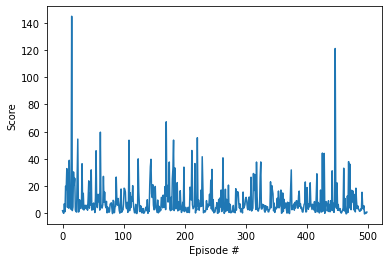

In [5]:
from dqn_agent import Agent
agent = Agent(state_size=1254, action_size=81, seed=42)

def dqn(n_episodes=500, max_t=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.999):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            action_map = agent.act_map[action]  # we map our return from a single value to our multidiscrete action
            next_state, reward, done, info = env.step(action_map)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
#         print('\rEpisode {}\tAverage Score: {:.2f}\n'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
## You can watch how your agent performs here
## Just ensure your environment is set to no_graphics=False

scores = []
n_test_episodes = 5
for i in range(n_test_episodes):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(agent.act_map[action])
        score += reward
    scores.append(score)

print('Average score over {} episodes is: {}'.format(n_test_episodes, round(sum(scores)/n_test_episodes, 2)))

In [6]:
env.close()

2021-06-08 16:09:29 INFO [environment.py:404] Environment shut down with return code 0.


## Concluding Thoughts

To train a well performing model, we most likely need to increase the number of episodes, `n_episodes`, and also increase the number of layers and nodes within each.
Furthermore, while DQN was one of the first deep RL algorithms to solve Atari, several advances in the field of RL have developed novel algorithms that outperform DQN.
Several of these algorithms are already tailored for use within the RLlib package.

`DroneDodgeBall` is a complex environment and will take significant time to solve.
Do not be discouraged if you are not getting good training results in a short period of time.

Below is an example of a larger model training for a longer period of time.

__Example Results of a Well Trained Model__

The following graph is a training log of a policy-based agent trained over 8 million steps (~60,000 episodes).
This training took about 16 hours on the MIT supercomputer.

![ray_learned](images/ray_learned.png)

It is important to remember that reinforcement learning alogrithms can take an extremely long time to train.
DeepMind AlphaStar, one of the most advanced RL algorithms that learned to play Starcraft, took over 46 years worth of training time on TPUv3s, some of the most powerful processors on the planet.